# Make circos plots ala [Yu et al.](https://www-sciencedirect-com.uaccess.univie.ac.at/science/article/pii/S0003267020309843)

In [1]:
import pandas as pd
import csv
import requests
from thefuzz import fuzz
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

def get_unambiguous_column_names(column_names):
    series = pd.Series(column_names)
    series[series.duplicated(keep = 'first')] = series[series.duplicated(keep = 'first')].apply(
        lambda x: x + '.1'
    )
    return series.to_list()

def parse_metabolomics_results(filename, delimiter = ',', quotechar = '"'):
    with open(filename) as csvfile:
        data = []
        entryid = None
        csvreader = csv.reader(
            csvfile,
            delimiter = delimiter,
            quotechar = quotechar
        )
        
        # get column names and make them unambiguous
        names = []
        for i in range(2):
            names = csvreader.__next__()
        
        names = get_unambiguous_column_names(names)
        
        add_names = [
                'Name2', 
                'Molecular Weight', 
                'RT [min]2', 
                'DeltaMass [ppm]', 
                'DBID', 
                'Reference List Name', 
                'mzLogic Score', 
                'ChemSpider ID', 
                'KEGG', 'HMDB', 
                'Mass List Search Results ID'
        ]
        add_names_set = set([k if not k in {'Name2', 'RT [min]2'} else k[:-1] for k in add_names]) # faster check
        series = None
        tmp_names = []
        add_rows = []
        
        def insert_addrow_into_series(series, names, values, add_names_set):
            series = series.copy()
            for k, v in zip(names, values):
                if k in add_names_set:
                    k = k + '2' if k in {'Name', 'RT [min]'} else k
                    series[k] = v if v else None

                elif k == 'KEGG ID':
                    series['KEGG'] = v if v else None
            
            return series
            
        for line in csvreader:
            if line[0]:
                if add_rows:
                    exact_match = False
                    partial_match = False
                    for row in add_rows:
                        if row[0] == series.Name:
                            data.append(
                                insert_addrow_into_series(
                                    series,
                                    tmp_names,
                                    row,
                                    add_names_set
                                )
                            )
                            exact_match = True
                            break
                    
                    if not exact_match:
                        for row in add_rows:
                            if fuzz.partial_ratio(row[0].lower(), series.Name.lower()) > 95:
                                data.append(
                                    insert_addrow_into_series(
                                        series,
                                        tmp_names,
                                        row,
                                        add_names_set
                                    )
                                )
                                partial_match = True
                                break
                    
                    if not partial_match:
                        data.append(series.copy())
                
                elif isinstance(series, pd.Series):
                    data.append(series.copy())
                    
                entryid = line[0]
                add_rows = []
                series = pd.Series(
                    {k: v for k, v in zip(names, line)}
                )
                
            elif line[1] == 'Name':
                tmp_names = [name for name in line if name]
            
            else:
                add_rows.append(line[1: 1 + len(tmp_names)])
    
    return pd.DataFrame(data, columns = names + add_names)

def clean_dataframe(df):
    no_kegg_rows = df.KEGG.isna()
    no_kegg = df.loc[no_kegg_rows, :].copy()
    kegg = df.loc[~no_kegg_rows, :].copy()
    for df in [kegg, no_kegg]:
        df.drop_duplicates(
            subset = ['ID', 'KEGG'],
            inplace = True
        )
    
    no_kegg = no_kegg.loc[~no_kegg.ID.isin(kegg.ID), :]
    return kegg, no_kegg

In [2]:
hilic = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_HILIC.csv')
hilic, no_kegg_hilic = clean_dataframe(hilic)
rp = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_RP.csv')
rp, no_kegg_rp = clean_dataframe(rp)

In [10]:
# combine hilic and rp in two different ways
def get_clean_coarse_group(x):
    x = x.split('/')[0].strip().lower()
    if x.startswith('bio'):
        x = 'bioenergetic process'
        
    elif x.startswith('nucleoside'):
        x = 'nucleoside metabolism'
    
    elif x.startswith('glycolysis'):
        x = 'glycolysis'
    
    elif x.startswith('lipid'):
        x = 'lipid metablism'
    
    elif x.startswith('purine'):
        x = 'nucleoside metabolism'
        
    elif x.startswith('aa'):
        x = 'aa metabolism'
        
    else:
        x = 'other'
        
    return x

basedata = {}
for key in ['RP', 'HILIC']:
    base = pd.read_csv(
        f'../raw/untargeted_Metabo_Results_LKnaus_annotated_DM_clean_annot_{key}.csv',
        header = 1
    ).loc[:, ['ID', 'Name Metabolite ', 'Group ']]
    base.columns = ['ID', 'metabolitename', 'metabolitegroupfine']
    base['metabolitegroupcoarse'] = base.metabolitegroupfine.apply(
        get_clean_coarse_group
    )

    frames = []
    for df in [hilic, no_kegg_hilic, rp, no_kegg_rp]:
        frames.append(
            base.merge(
                df,
                on = 'ID',
                how = 'inner'
            )
        )
    
    df = pd.concat(frames).reset_index(drop = True)
    df.index = df.ID.to_list()
    basedata[key] = df

In [4]:
basedata['HILIC'].metabolitegroupcoarse.unique()

array(['aa metabolism', 'other', 'bioenergetic process', 'glycolysis',
       'lipid metablism', 'nucleoside metabolism'], dtype=object)

In [5]:
basedata['RP'].metabolitegroupcoarse.unique()

array(['aa metabolism', 'other', 'bioenergetic process', 'glycolysis',
       'lipid metablism', 'nucleoside metabolism'], dtype=object)

In [12]:
import itertools as it
from scipy.stats import pearsonr

correlation_dict = {}
for base in ['HILIC', 'RP']:
    data = basedata[base].copy()
    # sorting to make sure groupings also appear lexicographically in pairs
    data.sort_values(
        by = 'metabolitegroupcoarse',
        inplace = True
    )
    correlation_dict[base] = {}
    for genotype in ['WT', 'KO']:
        correlation_dict[base][genotype] = {}
        for timepoint in ['E14_5', 'P2', 'P40']:
            gtdata = data.loc[
                :, 
                data.columns[
                    data.columns.str.match('S[0-9]{2}_' + timepoint + '_' + genotype + '[0-9]')
                ]
            ].astype(float)
            correlation_list = []
            for m1, m2 in it.combinations(gtdata.index, 2):
                correlation_list.append(
                    [
                        m1, 
                        data.loc[m1, 'metabolitegroupcoarse'], 
                        m2, 
                        data.loc[m2, 'metabolitegroupcoarse'], 
                        pearsonr(gtdata.loc[m1, :], gtdata.loc[m2, :])[0]
                    ]
                )
            
            correlation_dict[base][genotype][timepoint] = pd.DataFrame(
                correlation_list,
                columns = ['m1', 'group1', 'm2', 'group2', 'correlation']
            )

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


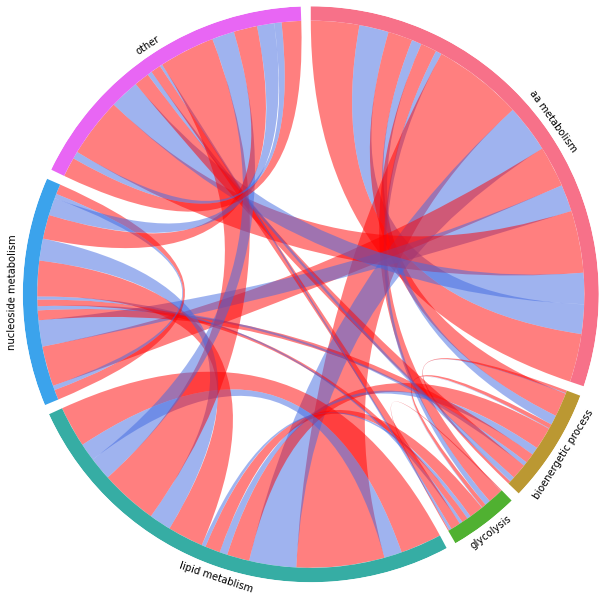

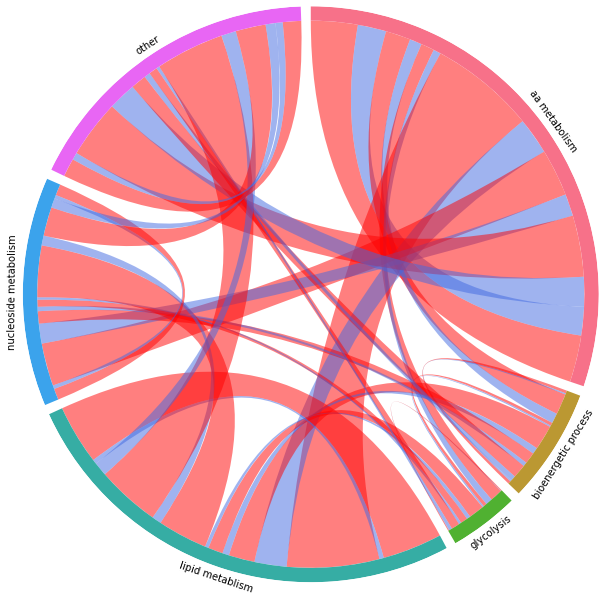

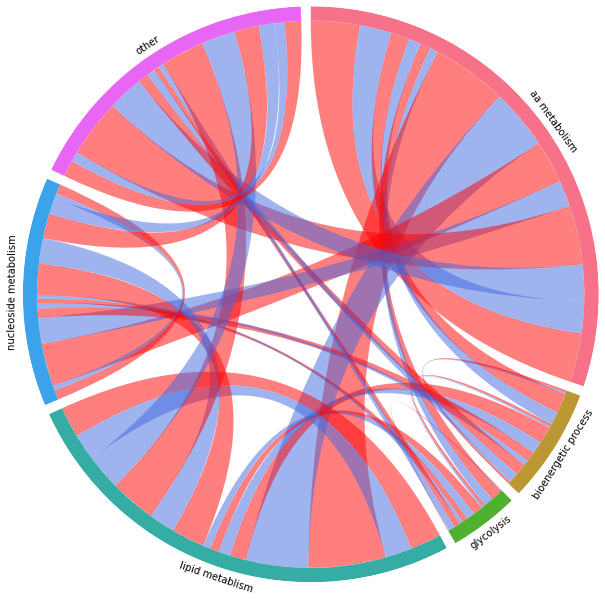

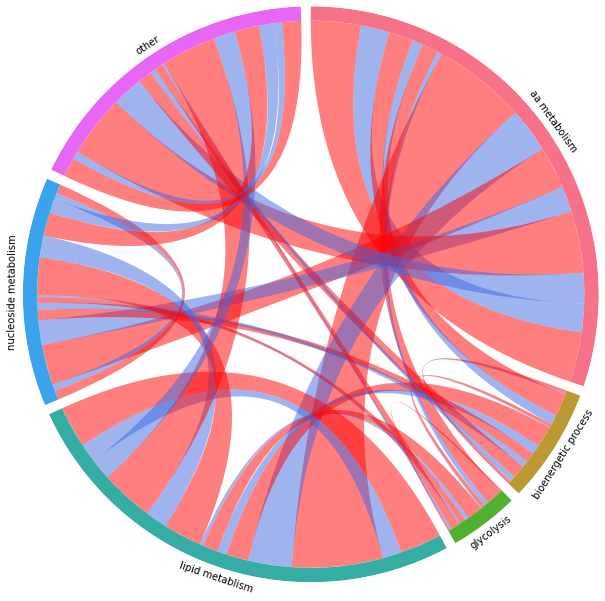

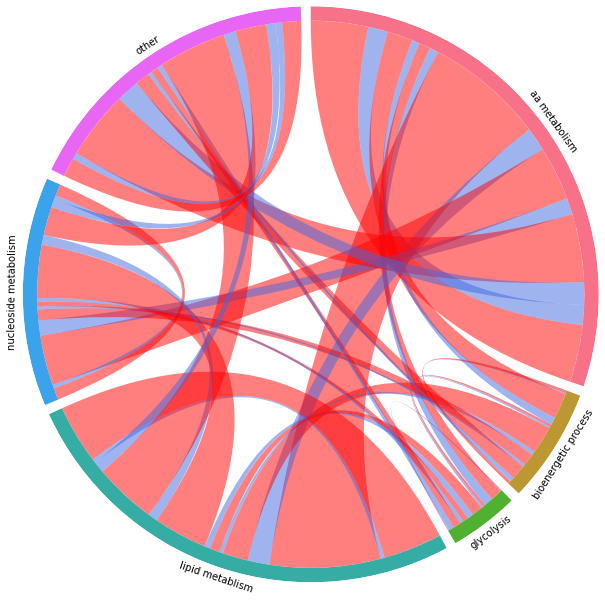

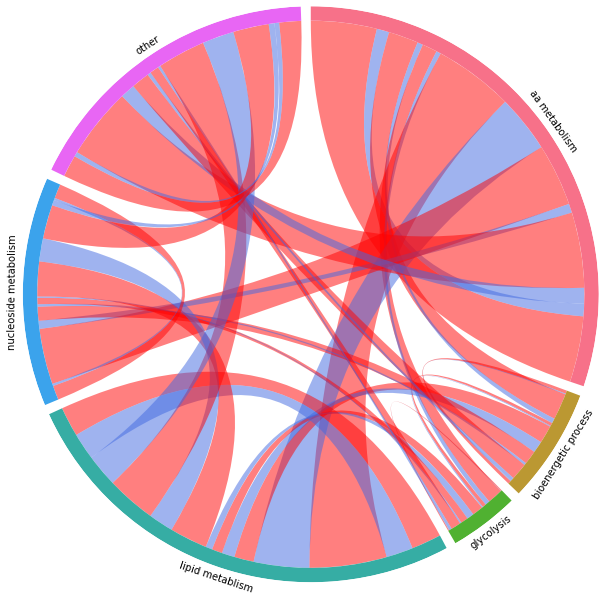

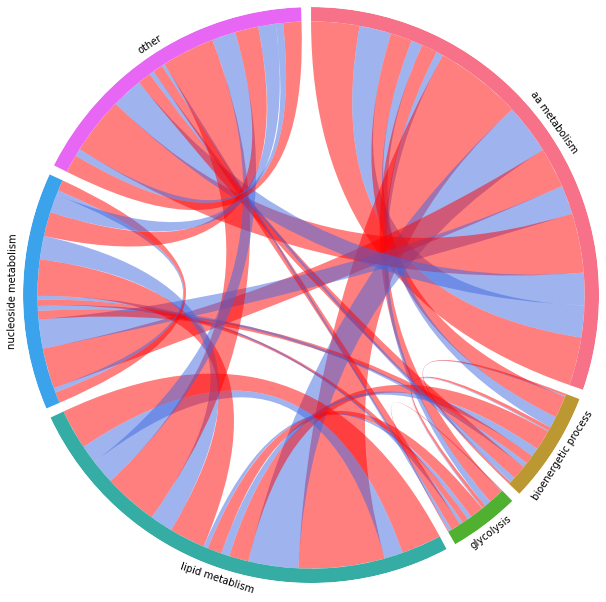

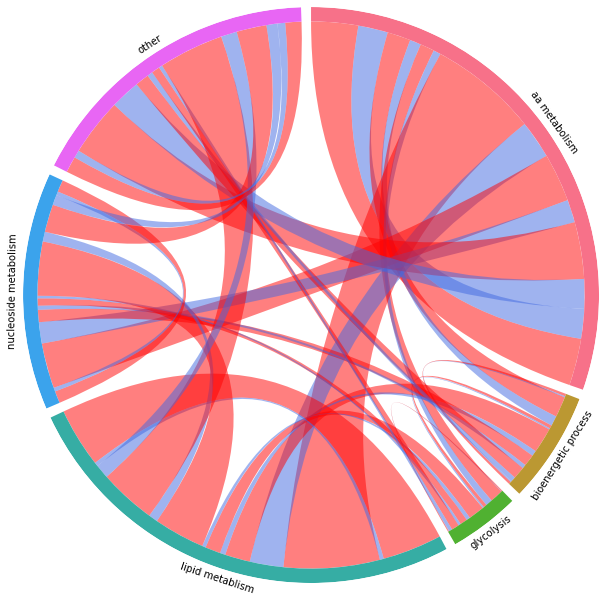

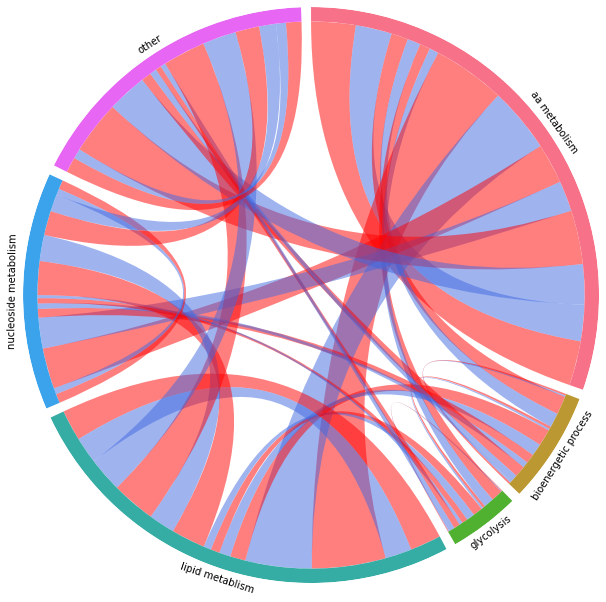

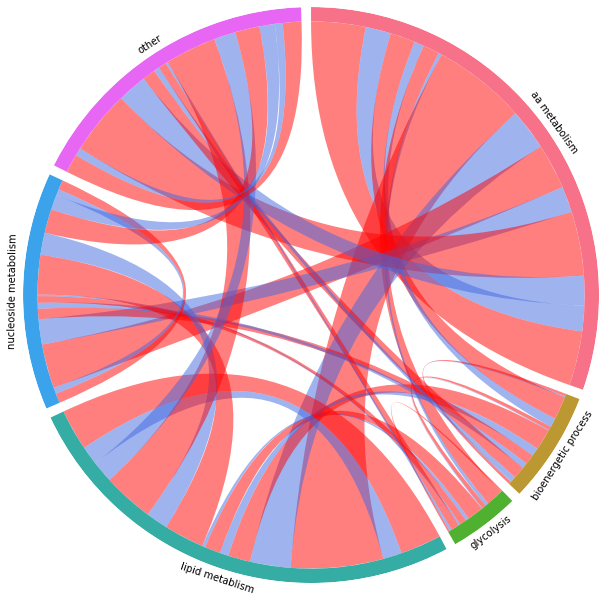

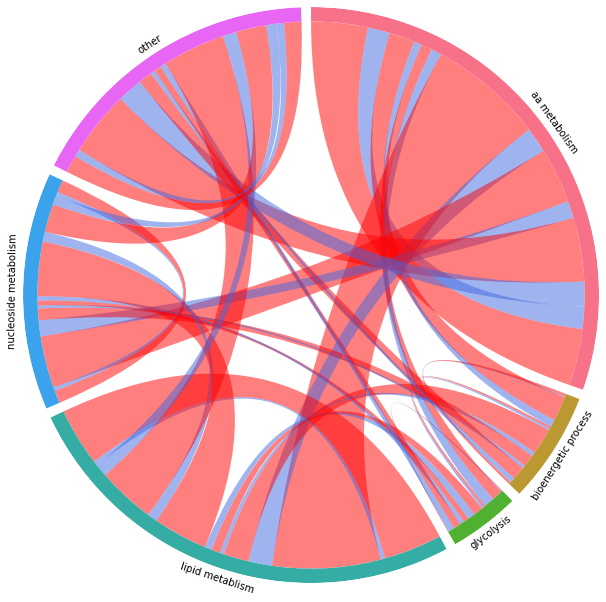

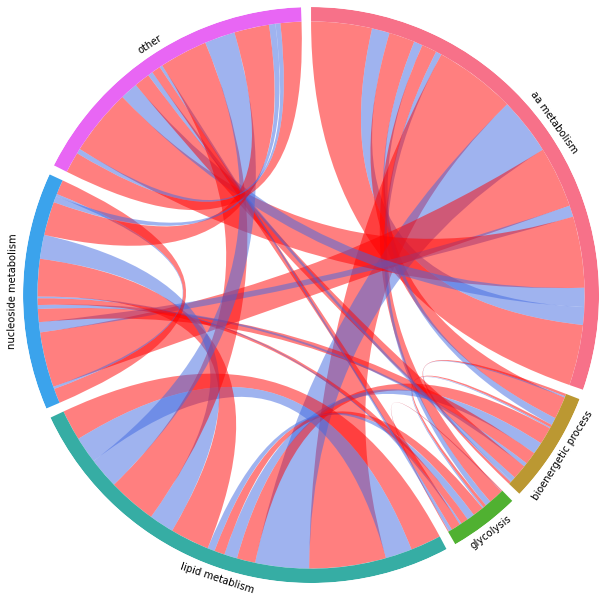

In [17]:
from pycircos import pycircos as pc
import seaborn as sns
from collections import defaultdict
from math import floor
from matplotlib import colors

def compute_length(
    number_of_correlations,
    garclength,
    total_number_of_correlations
):
    return floor(garclength * (number_of_correlations / total_number_of_correlations))

highlight_metabolites = False

for base in ['HILIC', 'RP']:
    data = basedata[base]
    palette = sns.color_palette('husl', data.metabolitegroupcoarse.nunique())
    multiplier = 1000
    for genotype, timepoint in it.product(['WT', 'KO'], ['E14_5', 'P2', 'P40']):
        # initialize figure
        circle = pc.Gcircle()
        for i, (name, group) in enumerate(data.groupby('metabolitegroupcoarse')):
            arc = pc.Garc(
                arc_id = name,
                size = len(group) * multiplier,
                labelposition = 60,
                raxis_range = (950, 1000),
                edgecolor = None,
                facecolor = palette[i],
                interspace = 2,
                label_visible = True
            )
            circle.add_garc(
                arc
            )
            
        circle.set_garcs()
        
        df = correlation_dict[base][genotype][timepoint]
        # cannot take total correlations as reference length 
        # because it might be different for each sample
        # thus we compute the lengths of each part via
        # a percentage of the total correlations for a given group
        # see compute_length
        total_correlations = defaultdict(int)
        for (group1, group2), corrs in df[df.correlation.abs() > 0.5].groupby(['group1', 'group2']):
            total_correlations[group1] += len(corrs)
            total_correlations[group2] += len(corrs)

        # get number of self correlations per group
        # and compute the startposition for non self arcs
        tmp = df[
            (df.correlation.abs() > 0.5) & 
            (df.group1 == df.group2)
        ]
        current_starts = {}
        for groups, row in tmp.groupby(['group1', 'group2']).count().iterrows():
            current_starts[groups[0]] = compute_length(
                row.m1,
                len(data[data.metabolitegroupcoarse == groups[0]]) * multiplier,
                total_correlations[groups[0]]
            )
        for groups, tmpdf in df.groupby(['group1', 'group2']):
            # computing set cardinalities
            lengths = {}
            for i, group in enumerate(groups):
                lengths[f'group{i}'] = len(
                    data[data.metabolitegroupcoarse == group]
                ) * multiplier

                for k, corrdf in zip(
                    ['pos', 'neg'],
                    [
                        tmpdf[tmpdf.correlation > 0.5],
                        tmpdf[tmpdf.correlation < -0.5]
                    ]
                ):
                    lengths[f'group{i}_{k}'] = compute_length(
                        len(corrdf),
                        lengths[f'group{i}'],
                        total_correlations[group]
                    )

            for corrtype, color in zip(
                ['pos', 'neg'],
                [
                    colors.to_rgba('red')[:-1] + (0.5,),
                    colors.to_rgba('royalblue')[:-1] + (0.5,)
                ]
            ):
                if not lengths[f'group{i}_{corrtype}']:
                    continue

                if groups[0] == groups[1]:
                    if corrtype == 'neg':
                        source = (
                            groups[0], 
                            lengths['group0_pos'], 
                            lengths['group0_pos'] + lengths['group0_neg'],
                            950
                        )
                        dest = (
                            groups[0], 
                            lengths['group0'] - lengths['group0_pos'] - lengths['group0_neg'], 
                            lengths['group0'] - lengths['group0_pos'], 
                            950
                        )
                    else:
                        source = (groups[0], 0, lengths['group0_pos'], 950)
                        dest = (
                            groups[0], 
                            lengths['group0'] - lengths['group0_pos'], 
                            lengths['group0'], 
                            950
                        )
                    coords = [source, dest]

                else:
                    coords = []
                    for i, group in enumerate(groups):
                        # catching groups that do not have self correlations
                        if not group in current_starts:
                            current_starts[group] = 0

                        coords.append(
                            (
                                group,
                                current_starts[group],
                                current_starts[group] + lengths[f'group{i}_{corrtype}'],
                                950
                            )
                        )
                        current_starts[group] += lengths[f'group{i}_{corrtype}']

                circle.chord_plot(
                    *coords,
                    facecolor = color
                )
        circle.figure.savefig(
            f'../plots/circos_metabolite_correlations_{genotype}_{timepoint}_{base}.pdf'
        )